In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pypesto import store

from inference.helper_functions import compute_error_estimate, compute_variance_estimate
from inference.nlme_objective import ObjectiveFunctionNLME

/Users/jonas.arruda/miniconda/envs/Amortized-NLME/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [51]:
# specify which model to use
model_name = ['fröhlich-simple', 'fröhlich-detailed', 'fröhlich-sde'][1]

  Activating project at `~/PyCharm Projects/Amortized-NLME/models/SimulatorFroehlich`


using 2 layers of MultiConv1D, a bidirectional LSTM with 256 units and a dense layer with output dimension 22 as summary network
using a 7-layer cINN as inference network with 2 layers of design spline
prior mean: [-1. -1. -1. 12. -1.  1. -1. -6.  0.  0. -1.]
prior covariance diagonal: [5. 5. 2. 1. 2. 2. 2. 5. 2. 5. 2.]
Using the model DetailedFroehlichModel


INFO:root:Performing 2 pilot runs with the DetailedFroehlichModel model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 11)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 180, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Loaded loss history from ../networks/amortizer-detailed-fro-sequence-summary-Bi-LSTM-7layers-2coupling-spline-500epochs/history_335.pkl.
INFO:root:Networks loaded from ../networks/amortizer-detailed-fro-sequence-summary-Bi-LSTM-7layers-2coupling-spline-500epochs/ckpt-335
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


Model: "amortized_posterior_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network_2 (Inve  multiple                  769265    
 rtibleNetwork)                                                  
                                                                 
 sequence_network_2 (Sequen  multiple                  610614    
 ceNetwork)                                                      
                                                                 
Total params: 1379879 (5.26 MB)
Trainable params: 1379725 (5.26 MB)
Non-trainable params: 154 (616.00 Byte)
_________________________________________________________________
None


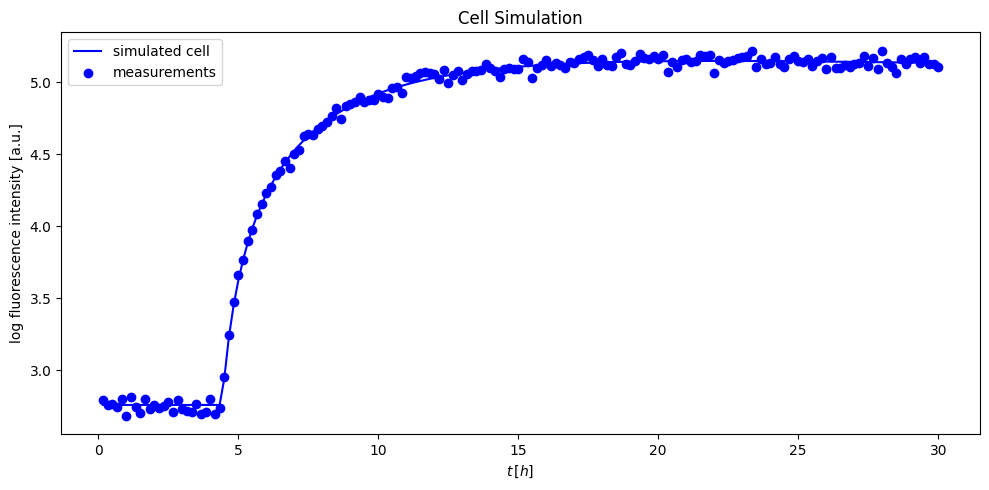

In [52]:
if model_name == 'fröhlich-simple':
    from models.froehlich_model_simple import FroehlichModelSimple
    individual_model = FroehlichModelSimple(load_best=True)
elif model_name == 'fröhlich-detailed':
    from models.froehlich_model_detailed import FroehlichModelDetailed
    individual_model = FroehlichModelDetailed(load_best=True)
elif model_name == 'fröhlich-sde':
    from models.froehlich_model_sde import FroehlichModelSDE
    individual_model = FroehlichModelSDE(load_best=True)    
else:
    raise NotImplementedError('model not implemented')

# assemble simulator and prior
trainer = individual_model.build_trainer('../networks/' + individual_model.network_name)
individual_model.plot_example()

In [53]:
obj_fun_amortized = ObjectiveFunctionNLME(model_name=individual_model.name,
                                          param_samples=np.empty((1,1,1)),
                                          prior_mean=individual_model.prior_mean,
                                          prior_std=individual_model.prior_std,
                                          covariance_format='diag',
                                          )

In [54]:
compute_relative_error = False  # relative to true parameter values

In [55]:
test_n_cells = [50, 100, 500, 5000, 10000]
n_samples_opt_list = [10, 50, 100, 250]
n_runs = 100
time_opt = np.ones((len(test_n_cells), len(n_samples_opt_list), n_runs)) * np.nan
amortized_error = np.ones((len(test_n_cells), len(n_samples_opt_list), n_runs)) * np.nan
amortized_var = np.ones((len(test_n_cells), len(n_samples_opt_list))) * np.nan
    
for nc, n_cells in enumerate(test_n_cells):
    for ns, n_samples in enumerate(n_samples_opt_list):
        # load results
        filename = f'synthetic_results_amortized/{individual_model.name}_cells_{n_cells}_samples_{n_samples}.hd5'
        result_optimization = store.read_result(filename)
        results_params = np.array(result_optimization.optimize_result.x)
        #assert results_params.shape[0] == n_runs, f'number of runs ({n_runs}) does not match number of results ({results_params.shape[0]})'
                
        # load true population parameters
        true_pop_parameters = individual_model.load_synthetic_parameter(n_data=n_cells)
        # set very small variances to 0.001
        true_pop_parameters[individual_model.n_params:][true_pop_parameters[individual_model.n_params:] < 0.001] = 0.001
        
        estimated_params_full = []
        for i_r, res in enumerate(results_params):
            # transform results
            estimated_beta = res[:individual_model.n_params]
            estimated_var = np.exp(-res[individual_model.n_params:individual_model.n_params*2])
            estimated_params = np.concatenate((estimated_beta, estimated_var))
                         
            # compute relative error of parameter estimated as minimum over multi_starts
            amortized_error[nc, ns, i_r] = compute_error_estimate(estimated_params,
                                                            true_pop_parameters,
                                                            bi_modal=True if 'Simple' in individual_model.name else False,
                                                            relative_error=compute_relative_error)
            estimated_params_full.append(estimated_params)
            
        amortized_var[nc, ns] = compute_variance_estimate(np.array(estimated_params_full))
             
        # get duration of optimization procedure (in seconds)
        time_opt[nc, ns] = np.array(result_optimization.optimize_result.time) / 60 / 60
#amortized_error.sort(axis=-1)

This problem is not to be used without a separately created objective.
INFO:pypesto.store.read_from_hdf5:WARNING: You are loading a problem.
This problem is not to be used without a separately created objective.
Loading the profiling result failed. It is highly likely that no profiling result exists within synthetic_results_amortized/DetailedFroehlichModel_cells_50_samples_10.hd5.
Loading the sampling result failed. It is highly likely that no sampling result exists within synthetic_results_amortized/DetailedFroehlichModel_cells_50_samples_10.hd5.
This problem is not to be used without a separately created objective.
INFO:pypesto.store.read_from_hdf5:WARNING: You are loading a problem.
This problem is not to be used without a separately created objective.
Loading the profiling result failed. It is highly likely that no profiling result exists within synthetic_results_amortized/DetailedFroehlichModel_cells_50_samples_50.hd5.
Loading the sampling result failed. It is highly likely that n

In [64]:
# read results from monolix
monolix_errors = np.ones(len(test_n_cells)) * np.nan
monolix_var = np.ones(len(test_n_cells)) * np.nan
timing_monolix = np.ones(len(test_n_cells)) * np.nan
timing_monolix_var = np.ones(len(test_n_cells)) * np.nan

if 'simple' in model_name:
    reorder_monolix_params = [0,1,2,3,4,10,5,6,7,8,9]
elif 'detailed' in model_name:
    monolix_param_names = np.array(['$\sigma$', '$\delta_1 m_0$', '$\delta_2$', '$e_0 m_0$', '$\gamma$', '$k_1 m_0$',
                           '$k_2$', '$k_2 m_0 scale$', 'offset',
                           'var-$\delta_1 m_0$', 'var-$\delta_2$', 'var-$e_0 m_0$', 'var-$\gamma$', 'var-$k_1 m_0$',
                           'var-$k_2$', 'var-$k_2 m_0 scale$', 'var-offset', 'var-$r_0 m_0$', 'var-$t_0$',
                           '$r_0 m_0$', '$t_0$'])
    reorder_monolix_params = [1,2,3,7,6,5,19,4,20,8,0,9,10,11,15,14,13,17,12,18,16]
    print(monolix_param_names[reorder_monolix_params])
    print(individual_model.param_names)
else:
    raise NotImplementedError('model not implemented')

for cell_idx, n_cells in enumerate(test_n_cells):    
    estimates_monolix = pd.read_csv(f'synthetic_results_monolix/{model_name}/estimates/synthetic_{n_cells}_poppars.csv',
                                    index_col=0, header=0)
    
    true_pop_parameters = individual_model.load_synthetic_parameter(n_data=n_cells)
    # set very small variances to 0.001
    true_pop_parameters[individual_model.n_params:][true_pop_parameters[individual_model.n_params:] < 0.001] = 0.001

    results_to_compare = []
    if 'detailed' in model_name: 
        for row_id, row in estimates_monolix.iterrows():
            temp_res = row.values[reorder_monolix_params]
            # standard deviation is not on log-scale
            temp_res[individual_model.n_params-1] = np.log(np.abs(temp_res[individual_model.n_params-1]))
            temp_res = np.concatenate((temp_res, [0.001]))  # add variance of noise
            results_to_compare.append(temp_res)
    else:
        for col in estimates_monolix.columns:
            temp_res = estimates_monolix[col].values[reorder_monolix_params]
            # standard deviation is not on log-scale
            temp_res[individual_model.n_params-1] = np.log(temp_res[individual_model.n_params-1])
            temp_res = np.concatenate((temp_res, [0.001]))  # add variance of noise
            results_to_compare.append(temp_res)
    error_mono = compute_error_estimate(np.array(results_to_compare), 
                                        true_pop_parameters, 
                                        bi_modal=True if 'Simple' in individual_model.name else False,
                                        relative_error=compute_relative_error)
    # take min over multi-starts
    error_mono.sort()
    monolix_errors[cell_idx] = np.median(error_mono)
    monolix_var[cell_idx] = compute_variance_estimate(np.array(results_to_compare))

    # results are sorted
    if os.path.exists(f'synthetic_results_monolix/{model_name}/estimates/synthetic_{n_cells}_likelihoods.csv'):
        best_runs = pd.read_csv(f'synthetic_results_monolix/{model_name}/estimates/synthetic_{n_cells}_likelihoods.csv', 
                                    index_col=0, header=0)['run']#[:10]
    else:
        # likelihood were not always available
        best_runs = pd.read_csv(f'synthetic_results_monolix/{model_name}/estimates/synthetic_{n_cells}_complete_likelihoods.csv', 
                                index_col=0, header=0)['run']#[:10]
    
    # get timing        
    timing_monolix_df = pd.read_csv(f'synthetic_results_monolix/{model_name}/optimization_times/synthetic_{n_cells}_timings.csv', 
                                 header=0)
    timing_monolix[cell_idx] = np.median(timing_monolix_df.saem / 60 / 60)  # in hours
    timing_monolix_var[cell_idx] = np.std(timing_monolix_df.saem / 60 / 60)  # in hours

['$\\delta_1 m_0$' '$\\delta_2$' '$e_0 m_0$' '$k_2 m_0 scale$' '$k_2$'
 '$k_1 m_0$' '$r_0 m_0$' '$\\gamma$' '$t_0$' 'offset' '$\\sigma$'
 'var-$\\delta_1 m_0$' 'var-$\\delta_2$' 'var-$e_0 m_0$'
 'var-$k_2 m_0 scale$' 'var-$k_2$' 'var-$k_1 m_0$' 'var-$r_0 m_0$'
 'var-$\\gamma$' 'var-$t_0$' 'var-offset']
['$\\delta_1 m_0$', '$\\delta_2$', '$e_0 m_0$', '$k_2 m_0 scale$', '$k_2$', '$k_1 m_0$', '$r_0 m_0$', '$\\gamma$', '$t_0$', 'offset', '$\\sigma$']


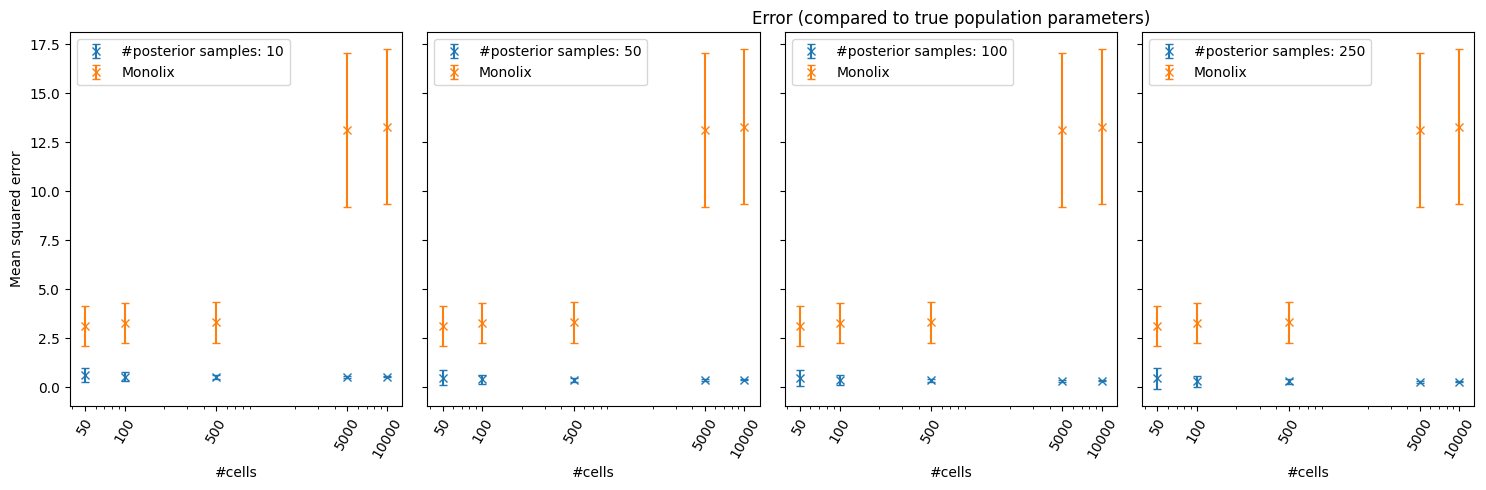

In [65]:
figure, axis = plt.subplots(nrows=1, ncols=len(n_samples_opt_list), tight_layout=True,
                            sharex='col', sharey='row', figsize=(15, 5))

for j, n_samples_opt in enumerate(n_samples_opt_list):
    axis[j].errorbar(np.array(test_n_cells), np.median(amortized_error[:, j], axis=1), np.sqrt(amortized_var[:, j]), alpha=1,
                  linestyle='None', marker='x', capsize=3, label=f'#posterior samples: {n_samples_opt}')

    axis[j].errorbar(test_n_cells, monolix_errors, np.sqrt(monolix_var), label='Monolix',
                     linestyle='None', marker='x', capsize=3)

    axis[j].set_xscale('log')
    axis[j].set_xlabel('#cells')
    axis[j].set_xticks(ticks=test_n_cells, labels=test_n_cells, rotation=60)
    axis[j].legend()
axis[0].set_ylabel('Relative mean squared error' if compute_relative_error else 'Mean squared error')
axis[len(n_samples_opt_list)//2].set_title('Error (compared to true population parameters)')
plt.show()

In [66]:
if 'simple' in model_name:
    average_training_time = 6.11
elif 'detailed' in model_name:
    average_training_time = 3.74 + 8.0
elif 'sde' in model_name:
    average_training_time = 2.16 + 5.12
else:
    raise NotImplementedError('model not implemented')

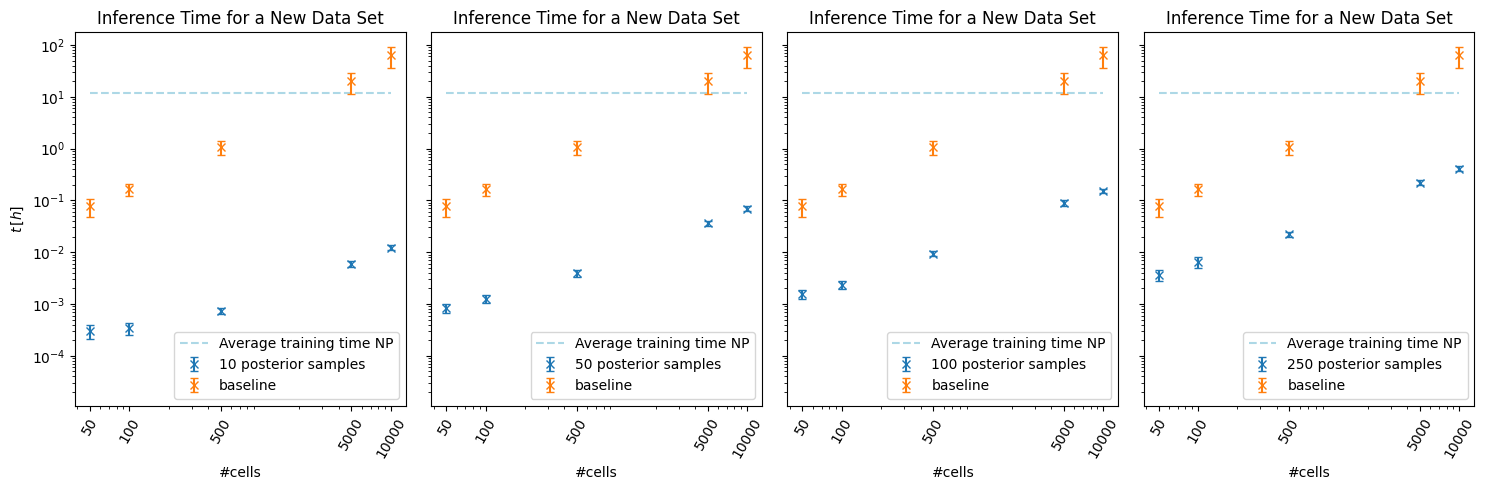

In [67]:
figure, axis = plt.subplots(nrows=1, ncols=len(n_samples_opt_list), sharey='row', figsize=(15, 5))

for j, n_samples_opt in enumerate(n_samples_opt_list):
    axis[j].hlines(average_training_time, xmin=test_n_cells[0], xmax=test_n_cells[-1], color='lightblue', linestyle='--',
               label=f'Average training time NP')
    #axis[j].scatter(test_n_cells, np.median(time_opt[:, j], axis=-1), 
    #                label=f'#posterior samples: {n_samples_opt}')
    axis[j].errorbar(test_n_cells, np.median(time_opt[:, j], axis=-1), np.std(time_opt[:, j], axis=-1), 
                     label=f'{n_samples_opt} posterior samples',
                     linestyle='None', marker='x', capsize=3)

    #axis[j].scatter(test_n_cells, timing_monolix, label=f'baseline')
    axis[j].errorbar(test_n_cells, timing_monolix, timing_monolix_var, label='baseline',
                     linestyle='None', marker='x', capsize=3)
    
    axis[j].set_xscale('log')
    axis[j].set_yscale('log')
    axis[j].set_title('Inference Time for a New Data Set')
    axis[j].legend(loc='lower right')
    axis[j].set_xlabel('#cells')
    axis[j].set_xticks(ticks=test_n_cells, labels=test_n_cells, rotation=60)
axis[0].set_ylabel('$t\,[h]$')
axis[0].set_ylim(axis[0].get_ylim()[0]*0.1, axis[0].get_ylim()[1])
plt.tight_layout()
plt.show()